<a href="https://colab.research.google.com/github/robertomoragad/Estadistica/blob/master/Sim_help_desk_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install simpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Cargamos librerias
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [152]:
#Inicio

#crear listas para almacenar datasets y su posterior análisis de resultados
wait_times_1 = [] #corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
wait_times_2 = [] #corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
support_times_1 = [] #corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
support_times_2 = [] #corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
total_times = [] #corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

RANDOM_SEED = 2 #fijar una semilla para correr 1 replica reproducible

#Creamos parametros del modelo:
NUM_EMPLOYEES_1 = 5     #Número de agentes en el proceso #1 del ciclo de trabajo
NUM_EMPLOYEES_2 = 7    #Número de agentes en el proceso #2 del ciclo de trabajo

#Tiempos de los 2 procesos secuenciales con gamma distribution
# proceso #1
alpha= 9.0
beta= 2.0
# proceso #2
alpha_2 = 7.0
beta_2= 3.5

SUPPORT_TIME_1 = alpha * beta  #Minutos promedio para el trabajo del proceso #1
SUPPORT_TIME_2 = alpha_2 * beta_2  #Minutos promedio para el trabajo del proceso #1
AVG_CUSTOMER_HOUR = 15 #en promedio llegan X tickets por hora al backlog del HelpDesk (esto es el lambda de poisson)
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada X minutos
SIM_TIME = 60*8*2        # tiempo de simulación en minutos

customers_handled = 0

class HelpDesk(object):
#Un Help Desk tiene un número limitado de agentes (empleados) para atender requerimientos de clientes
#El ciclo de vida del Requerimiento consta de 2 procesos (etapas) secuenciales (proceso #1 y proceso #2)
#Los clientes crean un Requerimiento, este ingresa a un Backlog donde debe esperar a uno de los agentes del primer proceso
#Cuando un Requerimiento consigue disponibilidad de un agente del primer proceso, comienza a ser atendido requerimiento hasta que finaliza el proceso #1
#Una vez finalizada la parte del primer proceso, el requerimiento entra al backlog del segundo proceso
#Cuando un Requerimiento consigue disponibilidad de un agente del segundo proceso, comienza a ser atendido hasta que finaliza el proceso #2 y allí finaliza la atención

    def __init__(self, env, num_employees_1, num_employees_2, support_time_1, support_time_2):
        self.env = env
        self.staff_1 = simpy.Resource(env, num_employees_1)
        self.staff_2 = simpy.Resource(env, num_employees_2)
        self.support_time_1 = support_time_1
        self.support_time_2 = support_time_2

    def support_1(self, customer):
        #El proceso #1 trabaja en la primera parte del Requerimiento
        random_time_1 = random.gammavariate(alpha, beta)
        yield self.env.timeout(random_time_1)
        print(f"Proceso #1 finalizado para Cliente {customer} at {self.env.now:.2f}")

    def support_2(self, customer):
        #El proceso #2 trabaja en la segunda parte del Requerimiento
        random_time_2 = random.gammavariate(alpha_2, beta_2)
        yield self.env.timeout(random_time_2)
        print(f"Proceso #2 finalizado para Cliente {customer} at {self.env.now:.2f}")

def customer(env, name, help_desk):
    #Los clientes (cada cliente tiene un nombre) crean Requerimientos en el Help Desk y para ser resueltos por agentes
    #Luego los Requerimiento de clientes comienzan a ser atendidos por un Agente del proceso #1, esperan hasta
    #que finaliza la la primera parte del trabajo del proceso #1, luego el requerimiento ingresa al backlog del proceso #2
    #El Requerimiento comienza a ser atendido por un Agente del proceso #2, los clientes esperan hasta que finaliza la segunda parte
    #del trabajo del proceso #2, y luego el Requerimiento finaliza por completo, saliendo del Help Desk (para no volver de nuevo..)  
    
    arrival_time = env.now #guarda el minuto de creación del Requerimiento del cliente
    global customers_handled
    print(f"Requerimiento Customer {name} enters waiting queue #1 at {env.now:.2f}!")
    with help_desk.staff_1.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un primer agente
        print(f"Customer {name} enters call #1 at {env.now:.2f}")
        start_support_time_1 = env.now #guarda el minuto en que se inicia la atención del cliente 
        wait_times_1.append(env.now - arrival_time) #calcula el tiempo de espera en la cola 1
        
        yield env.process(help_desk.support_1(name))
        # Cliente sale del primer proceso
        print(f"Customer {name} left call #1 at {env.now:.2f}")
        #customers_handled += 1       
        support_times_1.append(env.now - start_support_time_1) #calcula el tiempo de atención del proceso #1

    print(f"Customer {name} enters waiting queue #2 at {env.now:.2f}!")
    with help_desk.staff_2.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un segundo agente
        print(f"Customer {name} enters call #2 at {env.now:.2f}")
        start_support_time_2 = env.now #guarda el minuto en que se inicia la atención del cliente 
        #wait_times_2.append(env.now - arrival_time) #calcula el tiempo de espera en la cola 2
        
        yield env.process(help_desk.support_2(name))
        # Cliente sale del segundo proceso y finaliza la atención
        print(f"Customer {name} left call #2 at {env.now:.2f}")
        customers_handled += 1       
        support_times_2.append(env.now - start_support_time_2) #calcula el tiempo de atención del proceso #2
        total_times.append(env.now - arrival_time) #calcula el tiempo total (todo el proceso de atención)

def setup(env, num_employees_1, num_employees_2, support_time_1, support_time_2, customer_interval):
#Crea un Help Desk, un número inicial de clientes y luego se mantendrá creando clientes cada "CUSTOMER_INTERVAL" minutos
    #Crea el Help Desk
    help_desk = HelpDesk(env, num_employees_1, num_employees_2, support_time_1, support_time_2)

    #Crea 5 clientes iniciales
    for i in range(1, 2):
        env.process(customer(env, i, help_desk))

    #crea más clientes mientras la simulaciíon está corriendo
    while True:
        yield env.timeout(random.expovariate(1/customer_interval))
        i += 1
        env.process(customer(env, i, help_desk))


# Setup and start the simulation  
print("Starting Help Desk Simulation - for", SIM_TIME , "minutos")
random.seed(RANDOM_SEED)  #esto nos ayudará a reproducir los resultados

# Crea un environment e inicia el proceso setup
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL))

# Execute!
env.run(until=SIM_TIME)

print("Customer handled: " + str(customers_handled))


Starting Help Desk Simulation - for 960 minutos
Requerimiento Customer 1 enters waiting queue #1 at 0.00!
Customer 1 enters call #1 at 0.00
Proceso #1 finalizado para Cliente 1 at 10.11
Customer 1 left call #1 at 10.11
Customer 1 enters waiting queue #2 at 10.11!
Customer 1 enters call #2 at 10.11
Requerimiento Customer 2 enters waiting queue #1 at 12.50!
Customer 2 enters call #1 at 12.50
Requerimiento Customer 3 enters waiting queue #1 at 13.97!
Customer 3 enters call #1 at 13.97
Requerimiento Customer 4 enters waiting queue #1 at 17.45!
Customer 4 enters call #1 at 17.45
Requerimiento Customer 5 enters waiting queue #1 at 19.45!
Customer 5 enters call #1 at 19.45
Proceso #1 finalizado para Cliente 3 at 25.98
Customer 3 left call #1 at 25.98
Customer 3 enters waiting queue #2 at 25.98!
Customer 3 enters call #2 at 25.98
Requerimiento Customer 6 enters waiting queue #1 at 31.39!
Customer 6 enters call #1 at 31.39
Requerimiento Customer 7 enters waiting queue #1 at 31.50!
Customer 7 en

[42.66816688704138, 30.551743715357993, 46.189853587775154, 48.77622096532532, 35.80852801423569, 55.2004124924659, 50.822106619862815, 53.49272699790719, 54.88880886804569, 40.084123785471235, 70.60195337114293, 35.05381969721485, 47.40098313917325, 46.960292151902834, 36.31409679135453, 49.54186548426175, 29.478416948542602, 36.18332679410007, 55.39301721521444, 34.989104622647844, 65.55015907852548, 40.5508475640587, 43.63962702150249, 56.973124848457104, 45.67786011462559, 42.255054787491304, 47.76330391888524, 33.50137364993611, 36.88068381894209, 57.44461404170801, 49.19861954201468, 65.8797171304733, 52.01452096199105, 60.59269144197873, 59.72865239474322, 57.42981226545692, 61.499643540994725, 67.79183948912168, 72.25029285013196, 63.28117044831956, 76.0351160197549, 62.09345562095652, 61.89839866217247, 73.07391887235084, 60.09056120642515, 84.20445891177175, 78.11539163037222, 63.45740050153901, 57.169643826706846, 84.69810515737026, 58.836021011249215, 75.7423083243171, 83.1

<function matplotlib.pyplot.show(*args, **kw)>

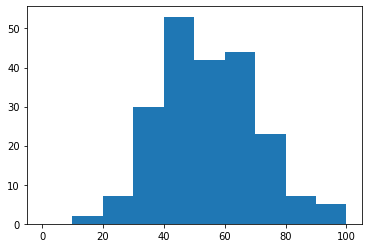

In [148]:
print(total_times)
print('n: ', len(total_times))
print('leadtime :', np.mean(total_times))
plt.hist(total_times, bins=10, range=(0, 100))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

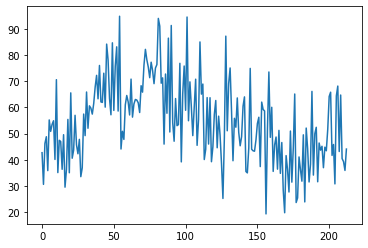

In [145]:
plt.plot(total_times)
plt.show

24.917515478512925


<function matplotlib.pyplot.show(*args, **kw)>

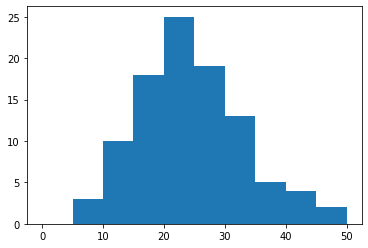

In [141]:
a = np.random.gamma(7, 3.5, 100)

print(np.mean(a))

plt.hist(a, bins=10, range=(0, 50))
plt.show